In [1]:
!pip install scanpy scvi-tools scikit-misc leidenalg torch adjustText

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.2/503.2 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.3 MB/s eta 0:00:00:00:0100:0

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
from scvi.external import SysVI
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from sklearn.metrics import silhouette_score

/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [3]:
arg = sc.read("/kaggle/input/final-scvi-datasets-input/arg_qc.h5ad")
pb1_batch = sc.read("/kaggle/input/final-scvi-datasets-input/pb1_qc.h5ad")
pb2_batch =  sc.read("/kaggle/input/final-scvi-datasets-input/pb2_qc.h5ad")

combined_hvgs = pd.read_csv("/kaggle/input/final-scvi-datasets-input/combined_hvgs (1).csv")

In [4]:
# Combine the datasets into one AnnData object
adata_combined = arg.concatenate(pb1_batch, pb2_batch, batch_key="batch")

adata_combined.obs["celltype"] = adata_combined.obs["celltype"].astype('category')

# Ensure unknown is a valid category
adata_combined.obs["celltype"] = adata_combined.obs["celltype"].cat.add_categories("Unknown")
# Replace NaNs with unknown safely
adata_combined.obs["celltype"] = adata_combined.obs["celltype"].fillna("Unknown")

/tmp/ipykernel_31/1204045253.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = arg.concatenate(pb1_batch, pb2_batch, batch_key="batch")


In [5]:
valid_genes = [gene for gene in list(combined_hvgs["Genes"]) if gene in adata_combined.var_names]
adata_combined = adata_combined[:, valid_genes].copy()

## Load the hyperparameter tuned model

In [6]:
scvi.settings.seed = 0
# Prepare the AnnData for querying with the saved model
scvi.model.SCVI.prepare_query_anndata(adata_combined, "/kaggle/input/scvi-model-hvg/other/default/1")

# Load the model
vae = scvi.model.SCVI.load("/kaggle/input/scvi-model-hvg/other/default/1", adata=adata_combined)

INFO: Seed set to 0


INFO     File /kaggle/input/scvi-model-hvg/other/default/1/model.pt already downloaded                             
INFO     Found 52.58145363408522% reference vars in query data.                                                    


/usr/local/lib/python3.11/dist-packages/scvi/model/base/_archesmixin.py:266: UserWarning: Query data contains less than 80% of reference var names. This may result in poor performance.
  return _pad_and_sort_query_anndata(adata, var_names, inplace)


INFO     File /kaggle/input/scvi-model-hvg/other/default/1/model.pt already downloaded                             


In [7]:
latent = vae.get_latent_representation()
adata_combined.obsm["X_scVI"] = latent
score = silhouette_score(adata_combined.obsm["X_scVI"], adata_combined.obs["batch"])
print("Silhouette Score by Batch (lower = better):", score)

score_ct = silhouette_score(adata_combined.obsm["X_scVI"], adata_combined.obs["celltype"])
print("Silhouette Score by Celltype (higher = better):", score_ct)

final_score = score_ct - score 
print("Silhouette Score by Celltype subtracted by Silhouette Score by Batch:", final_score)

Silhouette Score by Batch (lower = better): -0.00720864
Silhouette Score by Celltype (higher = better): 0.08851624
Silhouette Score by Celltype subtracted by Silhouette Score by Batch: 0.09572488


## Plot the UMAP for the learnt SCVI latent space

2025-04-26 23:35:25.386800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745710525.567836      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745710525.621734      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


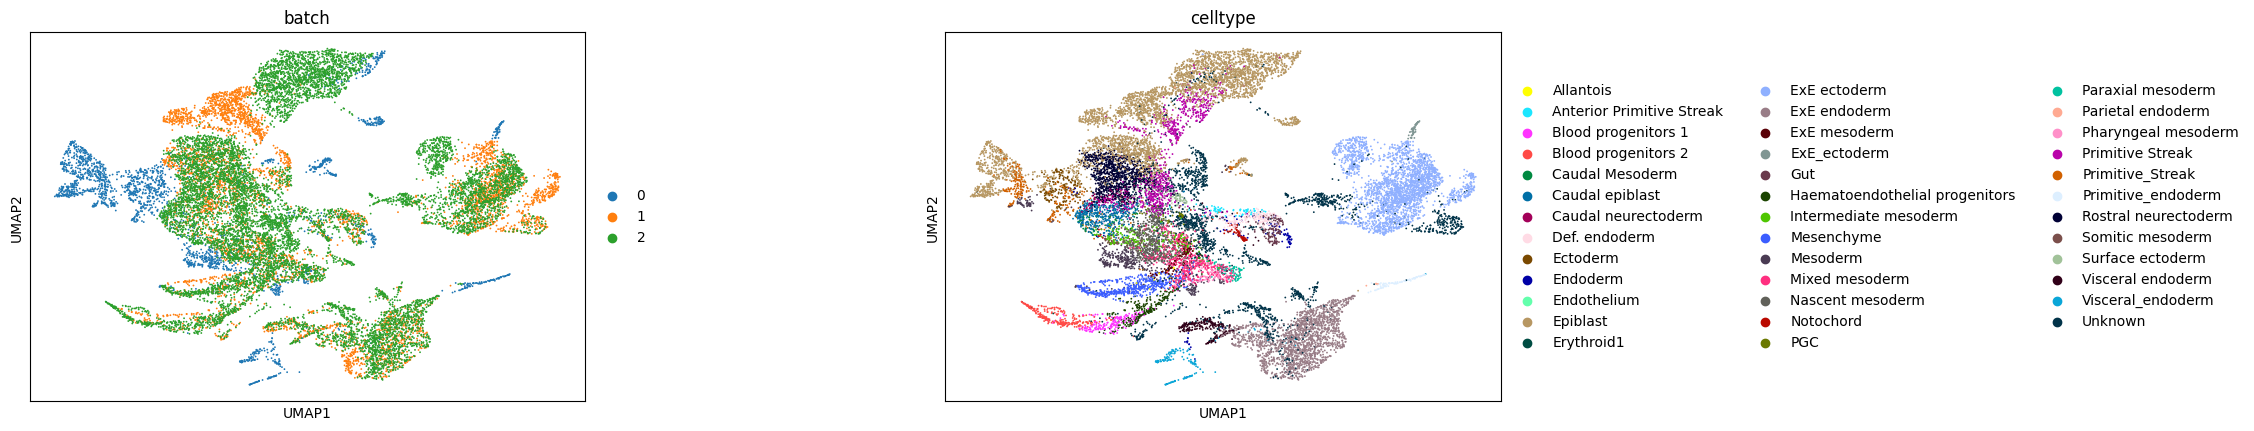

In [8]:
# Extract latent space
adata_combined.obsm["X_scVI"] = latent

# Compute neighbors for UMAP
sc.pp.neighbors(adata_combined, use_rep="X_scVI")
sc.tl.umap(adata_combined)

# Plot UMAP of SCVI latent space
sc.pl.umap(adata_combined, color=["batch", "celltype"], wspace=0.5)


... storing 'highlight' as categorical
... storing 'highlight' as categorical
... storing 'highlight' as categorical
... storing 'highlight' as categorical


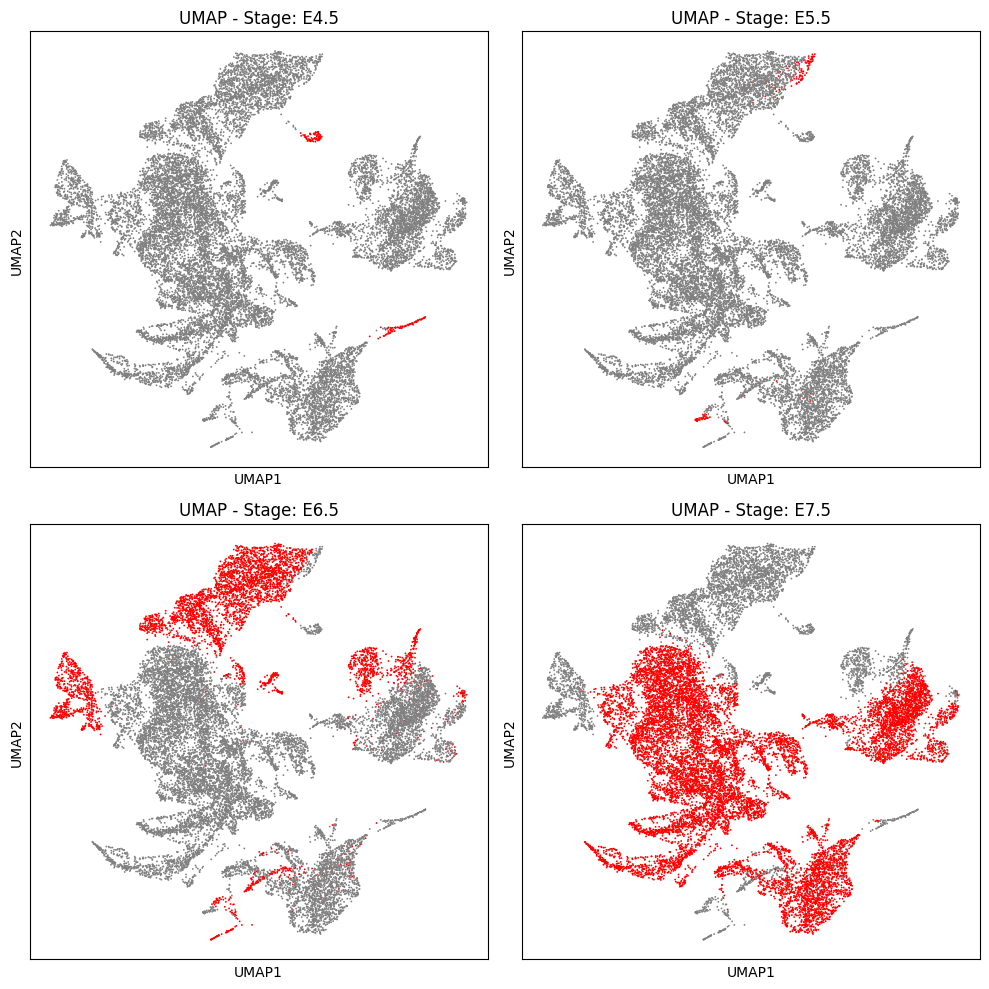

In [9]:
def sample_from_each_dev_stage(data):
  # Get the list of stages to be plotted 
  stages_to_plot = sorted(data.obs["stage"].unique())

  # Calculate the number of rows and columns needed to display the stages
  n_stages = len(stages_to_plot)
  n_cols = 2  
  n_rows = int(np.ceil(n_stages / n_cols))  

  # Create a grid of subplots
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(10,5  * n_rows))  
  axes = axes.flatten()  

  # Iterate through the stages and plot the UMAP for each
  for i, stage in enumerate(stages_to_plot):
    # Subset the data for the current stage and make sure UMAP is available
    stage_data = data.copy()  
    stage_data.obs["highlight"] = stage_data.obs["stage"].apply(lambda x: "highlight" if x == stage else "other")

    # Create the UMAP plot for this stage and assign it to the appropriate subplot
    sc.pl.umap(stage_data, color="highlight", palette={"highlight": "red", "other": "gray"},
               title=f"UMAP - Stage: {stage}", show=False, ax=axes[i], legend_loc=None)

  # Adjust layout to prevent overlap
  plt.tight_layout()
  plt.show()

sample_from_each_dev_stage(adata_combined)


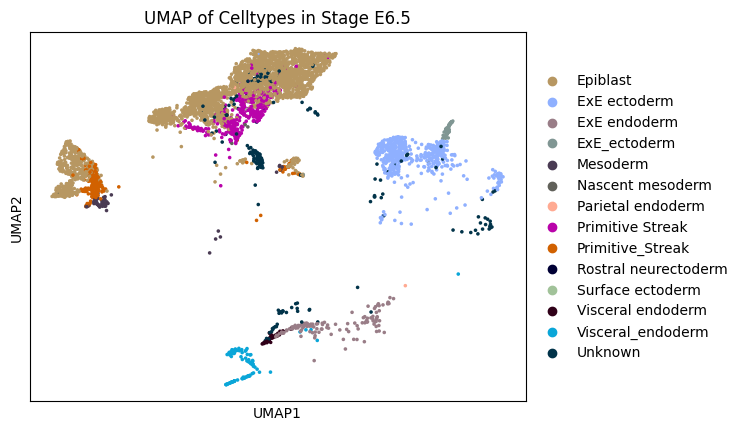

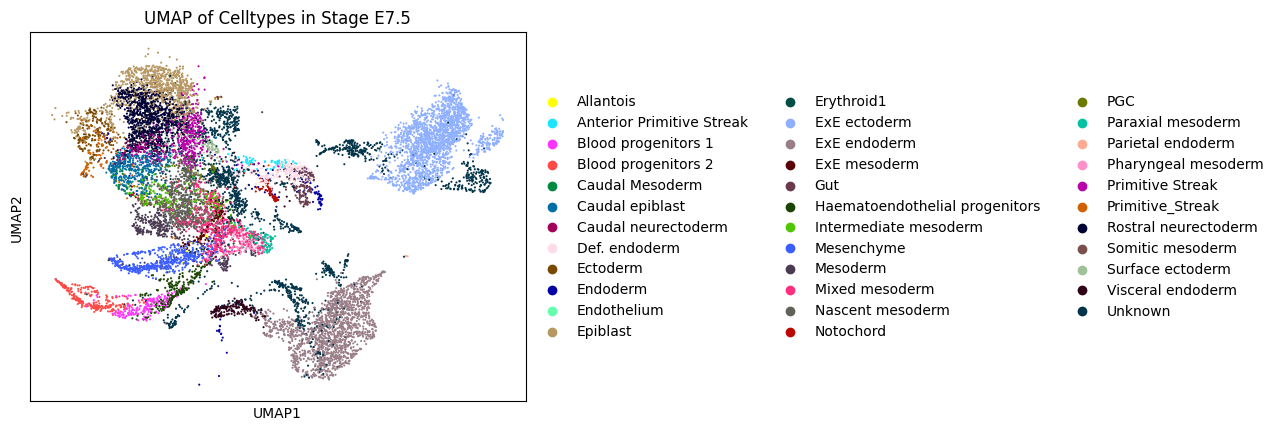

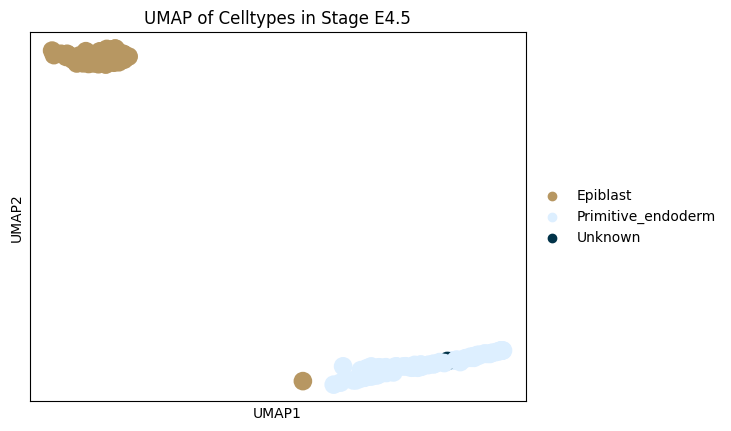

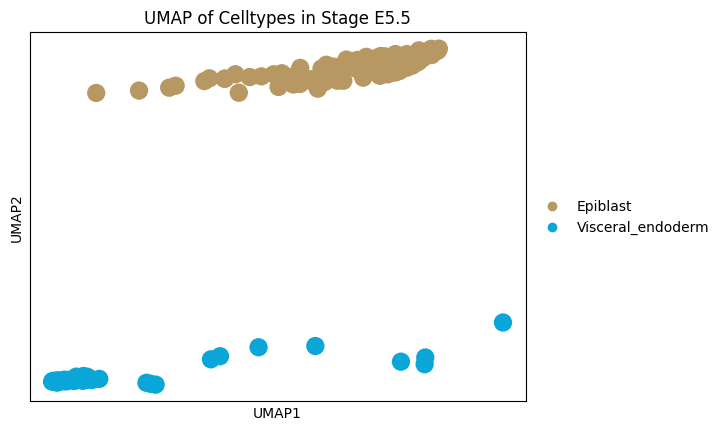

In [10]:
stages = adata_combined.obs["stage"].unique().tolist()

for stage in stages:
    subset = adata_combined[adata_combined.obs["stage"] == stage]
    sc.pl.umap(
        subset,
        color="celltype",
        title=f"UMAP of Celltypes in Stage {stage}",
        show=True
    )


/tmp/ipykernel_31/2611956057.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["batch", "stage"])



Pivot table:
 batch     0     1     2
stage                  
E4.5    167     0     0
E5.5    173     0     0
E6.5    921  1441  2130
E7.5   1098  3421  8465


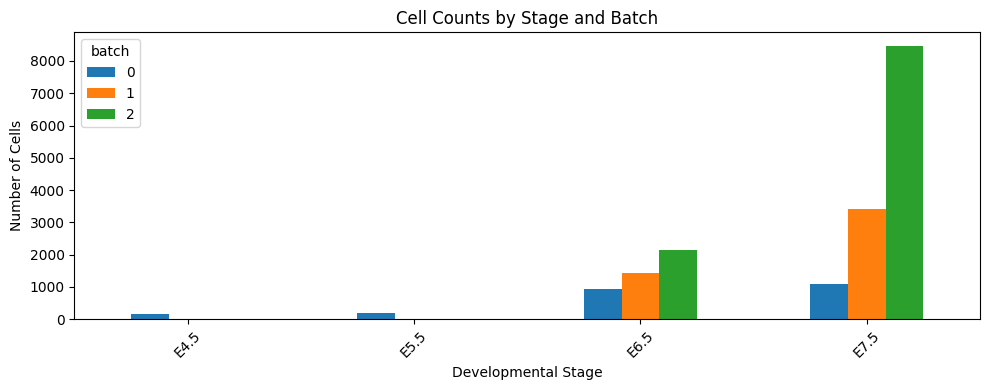

In [11]:
# Count number of cells by stage and batch
cell_counts = (
    adata_combined.obs
    .groupby(["batch", "stage"])
    .size()
    .reset_index(name="n_cells")
    .sort_values(by=["stage", "batch"])
)


#pivot 
cell_counts_pivot = cell_counts.pivot(index="stage", columns="batch", values="n_cells").fillna(0).astype(int)
print("\nPivot table:\n", cell_counts_pivot)

#bar plot
cell_counts_pivot.plot(kind="bar", figsize=(10, 4))
plt.title("Cell Counts by Stage and Batch")
plt.ylabel("Number of Cells")
plt.xlabel("Developmental Stage")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
gene_df = pd.read_csv("/kaggle/input/genenames/gene_names.csv")
gene_df.set_index("Gene stable ID", inplace=True)

In [13]:
def gene_name_mapping(data):
  # Map gene symbols and descriptions to adata.var
  data.var["gene_symbol"] = data.var_names.map(gene_df["Gene name"])
  data.var["gene_description"] = data.var_names.map(gene_df["Gene description"])

gene_name_mapping(adata_combined)

## Extracting the top 5 Genes in each stage

In [14]:
top_genes_all = []
all_de_results = []


for stage in adata_combined.obs["stage"].unique():
    print(f"Analyzing stage: {stage}")
    
    # Run DE one-vs-rest
    de_res = vae.differential_expression(
        groupby="stage",
        group1=stage,
        group2=None,
        batch_correction=True,
        mode="change",
        all_stats=True
    )

    all_de_results.append(de_res)
    
    # Clean 
    de_res = de_res.dropna(subset=["lfc_mean", "proba_de"]).copy()
    de_res["abs_lfc"] = de_res["lfc_mean"].abs()
    de_res["gene"] = de_res.index.map(adata_combined.var["gene_symbol"].to_dict())
    
    # Get top 5 for this stage
    top5 = (
        de_res[de_res["proba_de"] >= 0.70]
        .sort_values("abs_lfc", ascending=False)
        .dropna(subset=["gene"])
        .head(5)
    )
    top5["stage"] = stage
    top_genes_all.append(top5)

# Combine results
top_genes_df = pd.concat(top_genes_all).reset_index()
top_genes_df = top_genes_df[["stage", "gene", "lfc_mean", "proba_de"]]
print(top_genes_df)

Analyzing stage: E6.5


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing stage: E7.5


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing stage: E4.5


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing stage: E5.5


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

   stage    gene  lfc_mean  proba_de
0   E6.5  Dppa5a  2.661002  0.855742
1   E6.5    Utf1  2.299839  0.828932
2   E6.5  Pou3f1  2.126641  0.740096
3   E6.5  Cited2 -1.794787  0.809924
4   E6.5    Peg3 -1.629169  0.793117
5   E7.5  Dppa5a -2.906246  0.883153
6   E7.5    Utf1 -2.309546  0.834134
7   E7.5  Pou3f1 -1.953143  0.732293
8   E7.5  Cited2  1.784727  0.809524
9   E7.5     Wls  1.762212  0.720688
10  E4.5   Fabp3  4.115509  0.914766
11  E4.5    Mest -3.357763  0.714486
12  E4.5  Dppa5a  3.313423  0.904762
13  E4.5   Sparc  3.197129  0.781913
14  E4.5   Rhox5  3.129669  0.728491
15  E5.5  Dppa5a  3.111728  0.900760
16  E5.5     Mt1  2.611637  0.778711
17  E5.5     Mt2  2.462040  0.771309
18  E5.5   Hmga2 -2.037532  0.749100
19  E5.5    Fgf5  1.657067  0.716287


## Plot Volcano Plots for top 5 DEGs of each stage

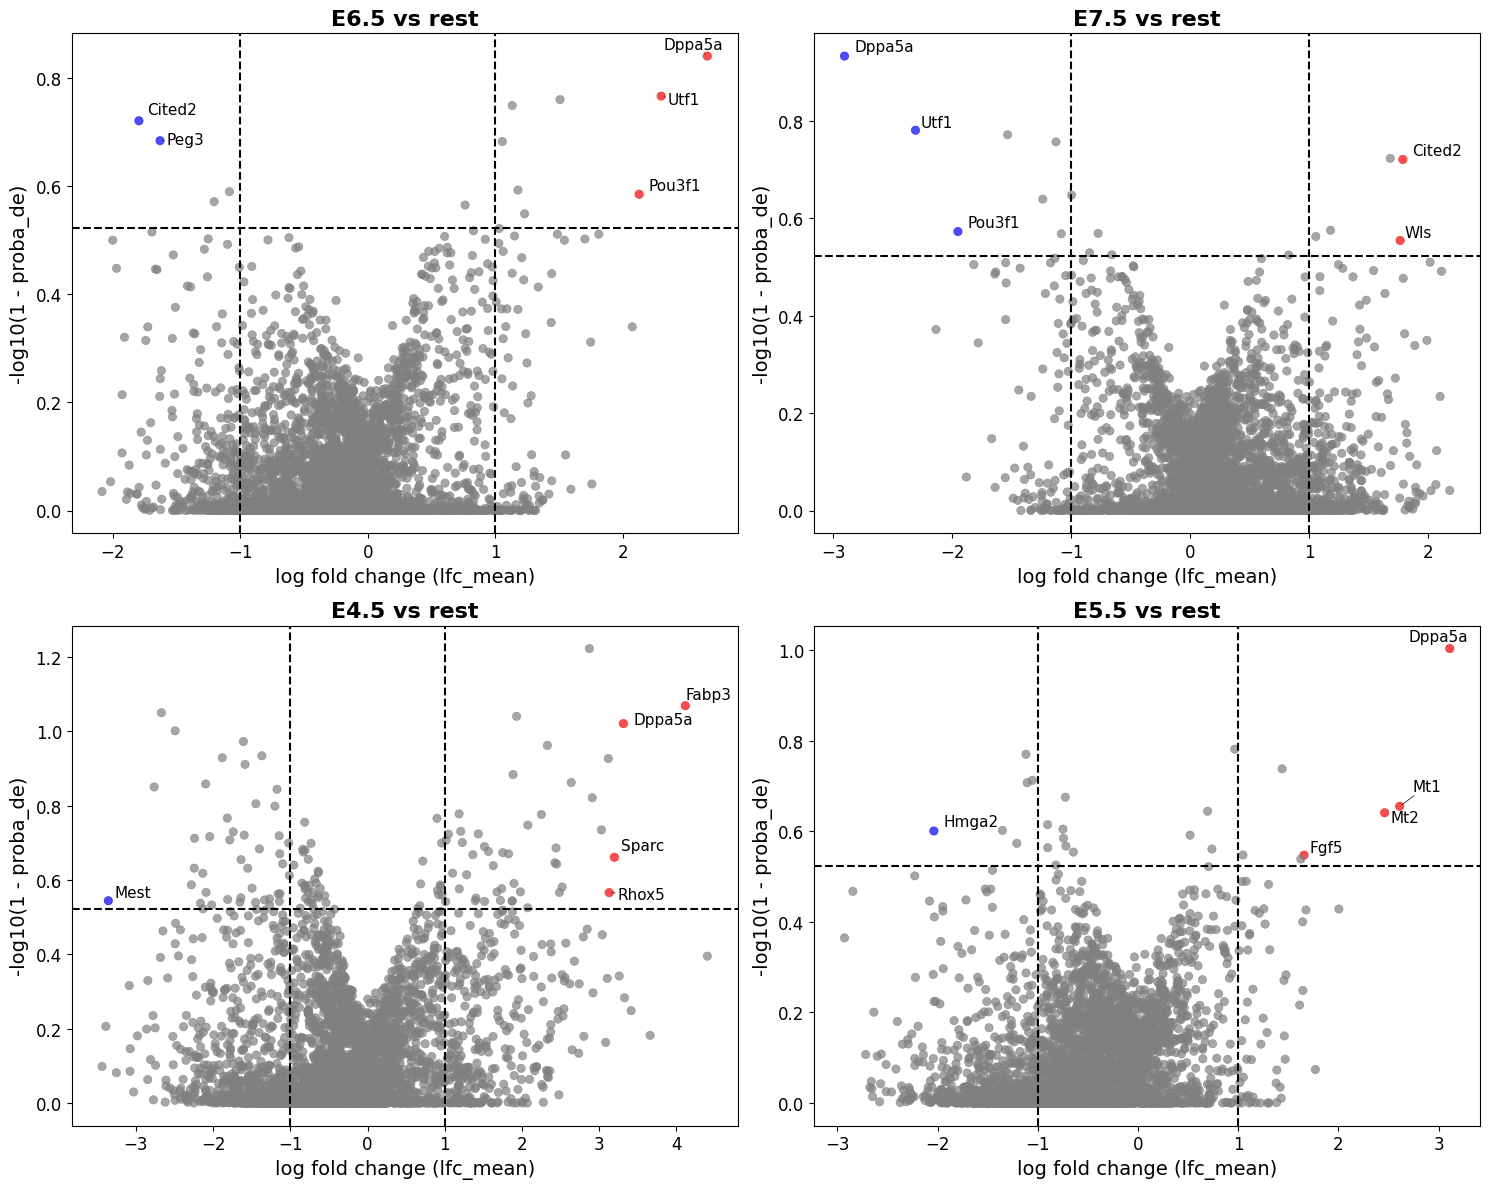

In [15]:
# Combine all DE results and add stage and gene names
stages = adata_combined.obs["stage"].unique().tolist()

for i, stage in enumerate(stages):
    all_de_results[i]["stage"] = stage
    all_de_results[i]["gene"] = all_de_results[i].index.map(adata_combined.var["gene_symbol"].to_dict())

all_de_df = pd.concat(all_de_results).reset_index()

# Set up 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Thresholds
lfc_threshold = 1
proba_threshold = 0.70
y_threshold = -np.log10(1 - proba_threshold)

for i, stage in enumerate(stages):
    ax = axes[i]
    de_df = all_de_df[all_de_df["stage"] == stage].copy()
    top_genes_stage = top_genes_df[top_genes_df["stage"] == stage]

    # Assign colors
    def gene_color(row):
        if row["gene"] in top_genes_stage["gene"].values:
            lfc = top_genes_stage[top_genes_stage["gene"] == row["gene"]]["lfc_mean"].values[0]
            return "red" if lfc > 0 else "blue"
        else:
            return "gray"

    de_df["color"] = de_df.apply(gene_color, axis=1)

    # Plot all genes
    sns.scatterplot(
        data=de_df,
        x="lfc_mean",
        y=-np.log10(1 - de_df["proba_de"]),
        hue="color",
        palette={"red": "red", "blue": "blue", "gray": "gray"},
        legend=False,
        alpha=0.7,
        edgecolor=None,
        ax=ax
    )

    # Draw threshold lines first
    ax.axvline(x=lfc_threshold, linestyle='--', color='black')
    ax.axvline(x=-lfc_threshold, linestyle='--', color='black')
    ax.axhline(y=y_threshold, linestyle='--', color='black')
  

    # Annotate top genes 
    texts = []
    for _, row in de_df[de_df["gene"].isin(top_genes_stage["gene"])].iterrows():
        y_val = -np.log10(1 - row["proba_de"])
        x_val = row["lfc_mean"]
        texts.append(ax.text(x_val, y_val, row["gene"], fontsize=11))

    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

    # Plot styling
    ax.set_title(f"{stage} vs rest", fontsize=16, fontweight='bold')
    ax.set_xlabel("log fold change (lfc_mean)", fontsize=14)
    ax.set_ylabel("-log10(1 - proba_de)", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()


{'heatmap_ax': <Axes: >, 'groupby_ax': <Axes: ylabel='celltype'>}

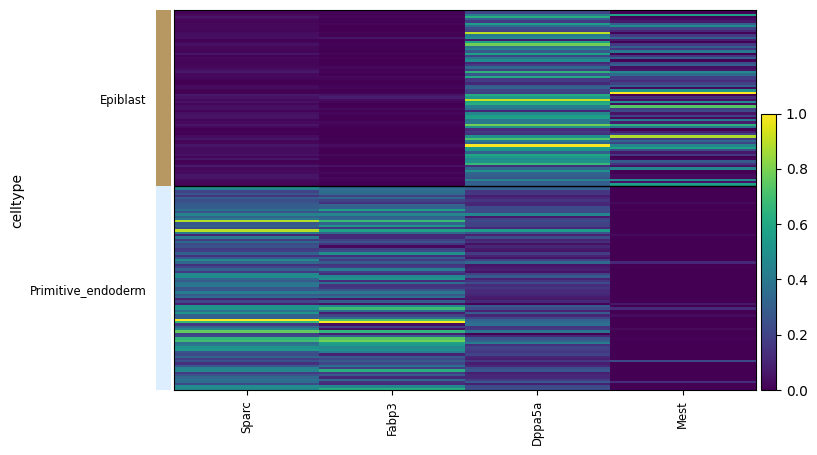

In [16]:
#Filter top genes for E4.5
e4_genes = top_genes_df[top_genes_df["stage"] == "E4.5"]["gene"].tolist()

#Subset to E4.5 cells
adata_e4 = adata_combined[adata_combined.obs["stage"] == "E4.5"].copy()

#Further subset to only epiblast and primitive_endoderm
adata_e4 = adata_e4[adata_e4.obs["celltype"].isin(["Epiblast", "Primitive_endoderm"])].copy()

#Define gene order
gene_order = ["Sparc", "Fabp3", "Dppa5a", "Mest"]

#Get corresponding ENSEMBL IDs in that order
ensembl_ordered = []
for gene in gene_order:
    match = adata_combined.var[adata_combined.var["gene_symbol"] == gene].index.tolist()
    if match:
        ensembl_ordered.append(match[0])

#Subset and rename
adata_e4_genes = adata_e4[:, ensembl_ordered].copy()
adata_e4_genes.var_names = gene_order  # use gene symbols as labels
adata_e4_genes.var_names_make_unique()

#Plot heatmap
sc.pl.heatmap(
    adata_e4_genes,
    var_names=gene_order,
    groupby="celltype",
    standard_scale="var",
    cmap="viridis",
    dendrogram=False,
    swap_axes=False,      
    figsize=(8, 5),
    show=False
)

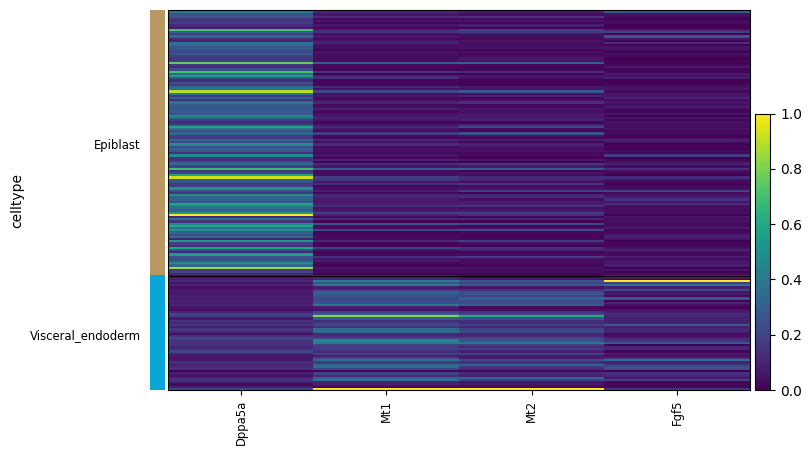

In [17]:
#Filter top genes for E5.5
e5_genes = top_genes_df[top_genes_df["stage"] == "E5.5"]["gene"].tolist()

#Subset cells for E5.5 stage
adata_e5 = adata_combined[adata_combined.obs["stage"] == "E5.5"].copy()

#Define gene order  
gene_order = ["Dppa5a", "Mt1", "Mt2", "Fgf5"]  

#Get corresponding ENSEMBL IDs in that order
ensembl_ordered = []
for gene in gene_order:
    match = adata_combined.var[adata_combined.var["gene_symbol"] == gene].index.tolist()
    if match:
        ensembl_ordered.append(match[0])

#Subset and rename
adata_e5_genes = adata_e5[:, ensembl_ordered].copy()
adata_e5_genes.var_names = gene_order  # set to ordered gene symbols
adata_e5_genes.var_names_make_unique()

sc.pl.heatmap(
    adata_e5_genes,
    var_names=gene_order,
    groupby="celltype",  
    standard_scale="var",
    cmap="viridis",
    dendrogram=False,
    swap_axes=False,
    figsize=(8, 5),
    show=True
)

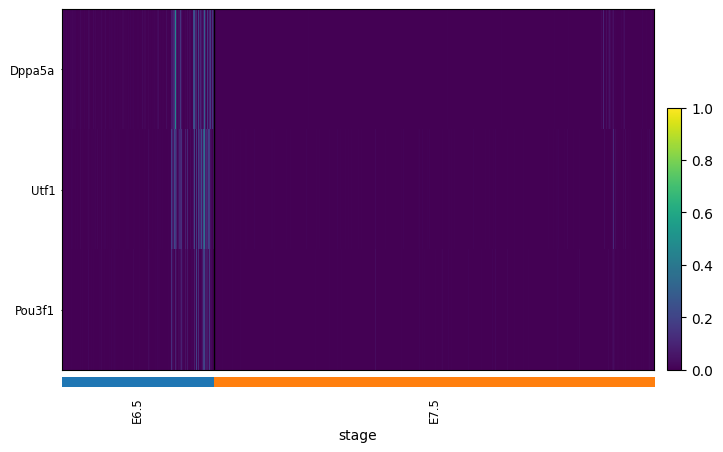

In [18]:
#Genes of interest
genes = ["Dppa5a", "Utf1", "Pou3f1"]

#Subset to E6.5 & E7.5 cells
adata_e6e7 = adata_combined[adata_combined.obs["stage"].isin(["E6.5", "E7.5"])].copy()

#Map to ENSEMBL IDs 
ensembl_ids = [
    adata_combined.var[
        adata_combined.var["gene_symbol"] == g
    ].index[0]
    for g in genes
]

#Subset and rename var_names to gene symbols
adata_e6e7_genes = adata_e6e7[:, ensembl_ids].copy()
adata_e6e7_genes.var_names = genes
adata_e6e7_genes.var_names_make_unique()

#Plot heatmap
sc.pl.heatmap(
    adata_e6e7_genes,
    var_names=genes,
    groupby="stage",
    standard_scale="var",
    cmap="viridis",
    dendrogram=False,
    swap_axes=True,    
    figsize=(8, 5),
    show=True
)


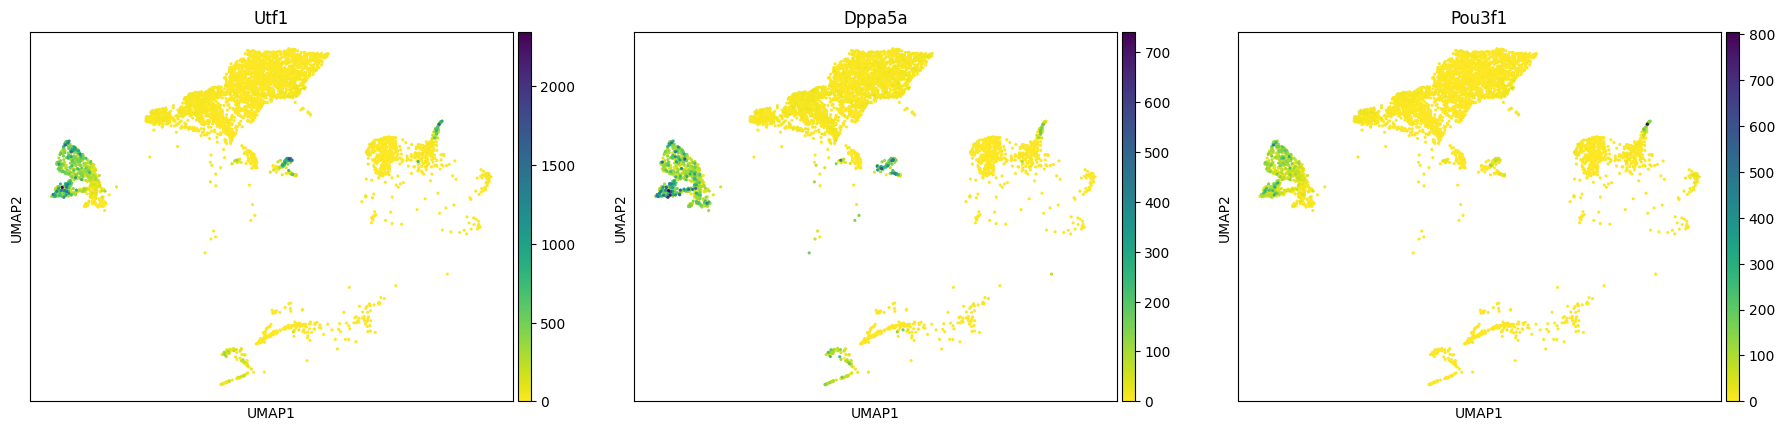

In [19]:
#Get up-regulated genes for E6.5
e6_up = (
    top_genes_df
    .query('stage == "E6.5" and lfc_mean > 0')
    ["gene"]
    .tolist()
)

#Map gene symbols to ENSEMBL IDs
ensembl_e6 = adata_combined.var.loc[
    adata_combined.var["gene_symbol"].isin(e6_up),
].index.tolist()

#Subset to E6.5 cells
adata_e6 = adata_combined[adata_combined.obs["stage"] == "E6.5"].copy()

#Rename var_names to symbols 
adata_e6_plot = adata_e6[:, ensembl_e6].copy()
adata_e6_plot.var_names = adata_combined.var.loc[ensembl_e6, "gene_symbol"].values
adata_e6_plot.var_names_make_unique()


#Plot one UMAP per gene
sc.pl.umap(
    adata_e6_plot,
    color=adata_e6_plot.var_names,
    use_raw=False,       
    cmap="viridis_r",
    size=20,
    ncols=3,             
    title=adata_e6_plot.var_names,
    show=True
)


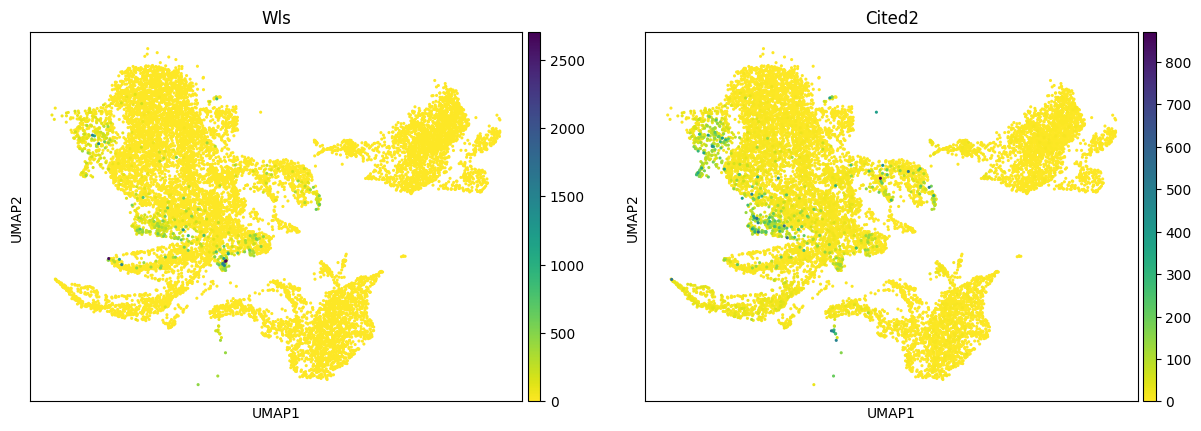

In [20]:
#Get up-regulated genes for E7.5
e7_up = (
    top_genes_df
    .query('stage == "E7.5" and lfc_mean > 0')
    ["gene"]
    .tolist()
)

#Map gene symbols to ENSEMBL IDs
ensembl_e7 = adata_combined.var.loc[
    adata_combined.var["gene_symbol"].isin(e7_up),
].index.tolist()

#Subset to E7.5 cells
adata_e7 = adata_combined[adata_combined.obs["stage"] == "E7.5"].copy()

#Rename var_names to gene symbols 
adata_e7_plot = adata_e7[:, ensembl_e7].copy()
adata_e7_plot.var_names = adata_combined.var.loc[ensembl_e7, "gene_symbol"].values
adata_e7_plot.var_names_make_unique()

#Plot one UMAP per gene 
sc.pl.umap(
    adata_e7_plot,
    color=adata_e7_plot.var_names,
    use_raw=False,       
    cmap="viridis_r",    
    size=20,
    ncols=3,            
    title=adata_e7_plot.var_names,
    show=True
)


## Extract Top 5 Genes Overall

Analyzing stage: E6.5


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing stage: E7.5


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing stage: E4.5


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing stage: E5.5


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

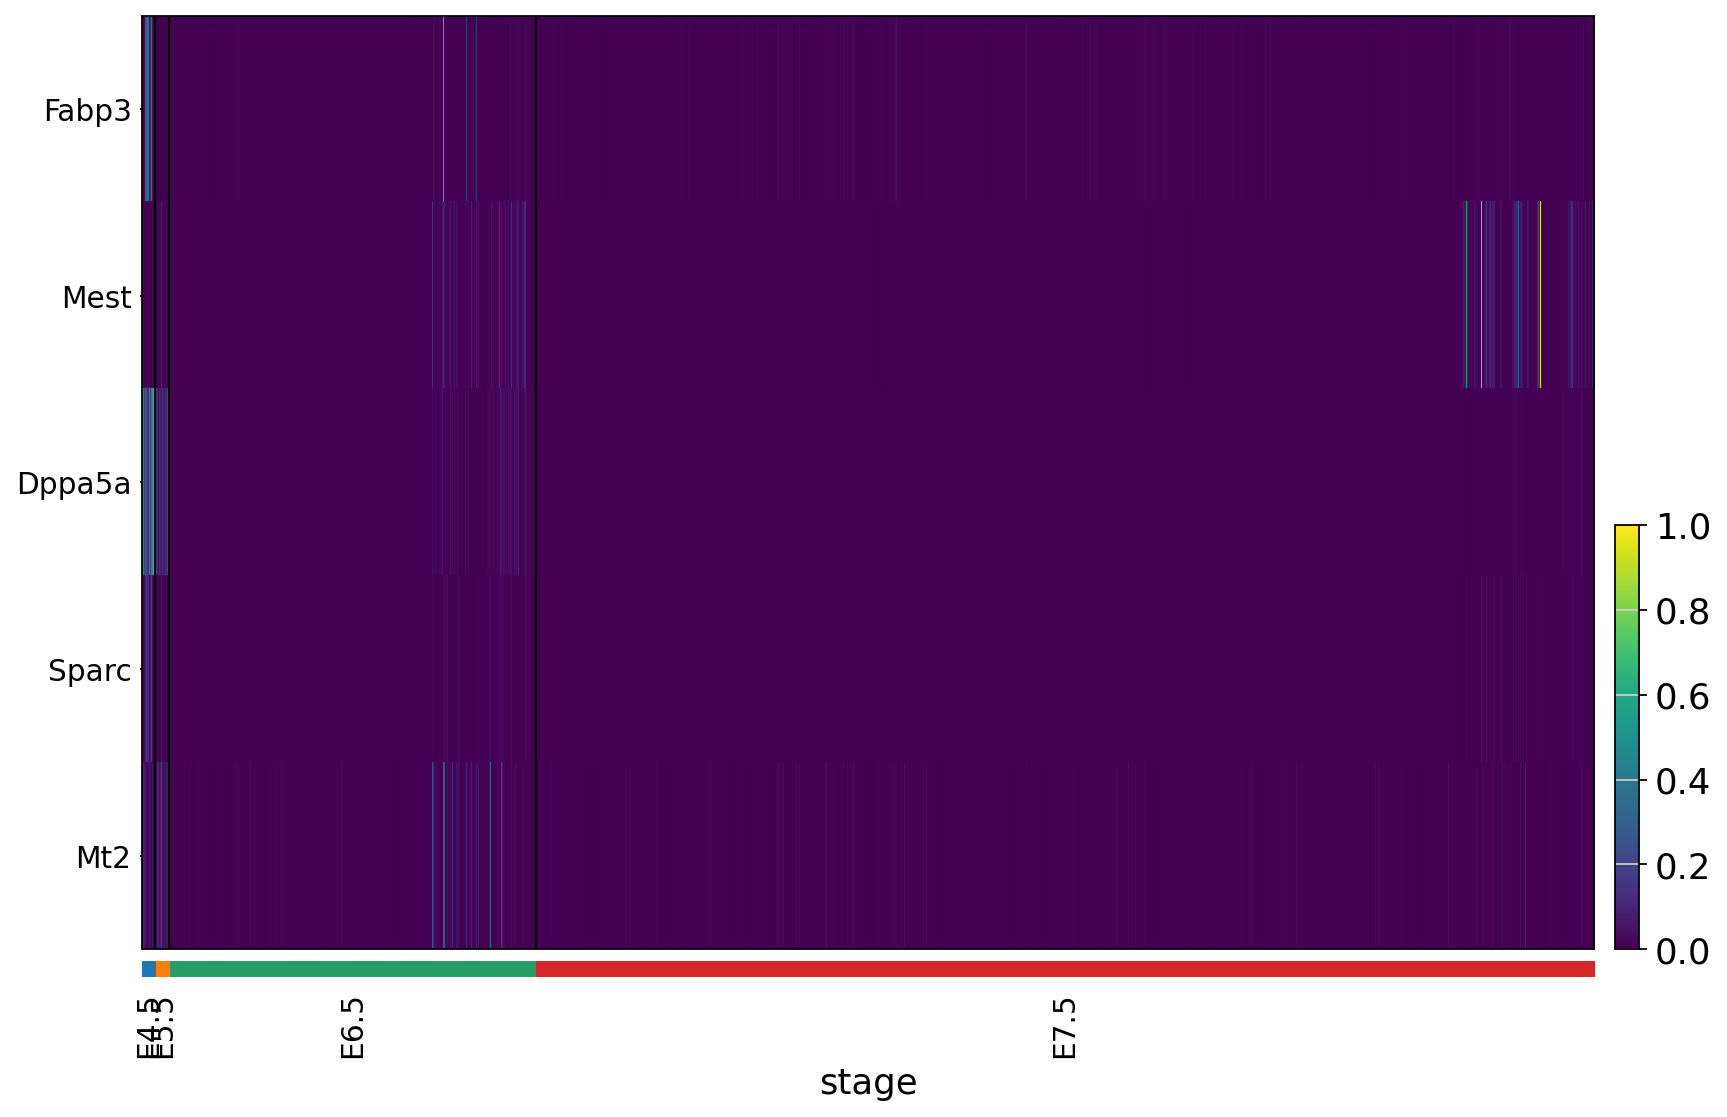

In [21]:
top_genes_all = []
sc.set_figure_params(scanpy=True, fontsize=16)  

symbol_to_ensembl = adata_combined.var["gene_symbol"].dropna().to_dict()
ensembl_from_symbol = {v: k for k, v in symbol_to_ensembl.items()}

for stage in adata_combined.obs["stage"].unique():
    print(f"Analyzing stage: {stage}")
    
    # Run DE - one-vs-rest for each stage
    de_res = vae.differential_expression(
        groupby="stage",
        group1=stage,
        group2=None,
        batch_correction=True,
        mode="change",
        all_stats=True
    )
    

    de_res = de_res.dropna(subset=["lfc_mean", "proba_de"]).copy()
    de_res["abs_lfc"] = de_res["lfc_mean"].abs()
    de_res["gene"] = de_res.index.map(adata_combined.var["gene_symbol"].to_dict())
    

    top_genes_all.append(de_res)


de_res_all = pd.concat(top_genes_all).reset_index(drop=True)


top_degs = (
    de_res_all[de_res_all["proba_de"] >= 0.70]  
    .sort_values("abs_lfc", ascending=False)  
    .dropna(subset=["gene"])  
    .head(5)  
)


top_genes_symbols = top_degs["gene"].unique()
top_genes_ensembl = [ensembl_from_symbol[g] for g in top_genes_symbols if g in ensembl_from_symbol]

ensembl_to_symbol = adata_combined.var["gene_symbol"].to_dict()
top_gene_symbols = [ensembl_to_symbol[ens] for ens in top_genes_ensembl]

adata_top_genes = adata_combined[:, top_genes_ensembl]

adata_temp = adata_top_genes.copy()
adata_temp.var_names = top_gene_symbols  

sc.pl.heatmap(
    adata_temp,
    var_names=top_gene_symbols , 
    groupby="stage",  
    standard_scale="var",  
    cmap="viridis",  
    dendrogram=False,  
    figsize=(12, 8),  
    show=True,  
    swap_axes=True,
)

## Alternative Approach (Not included in final results)

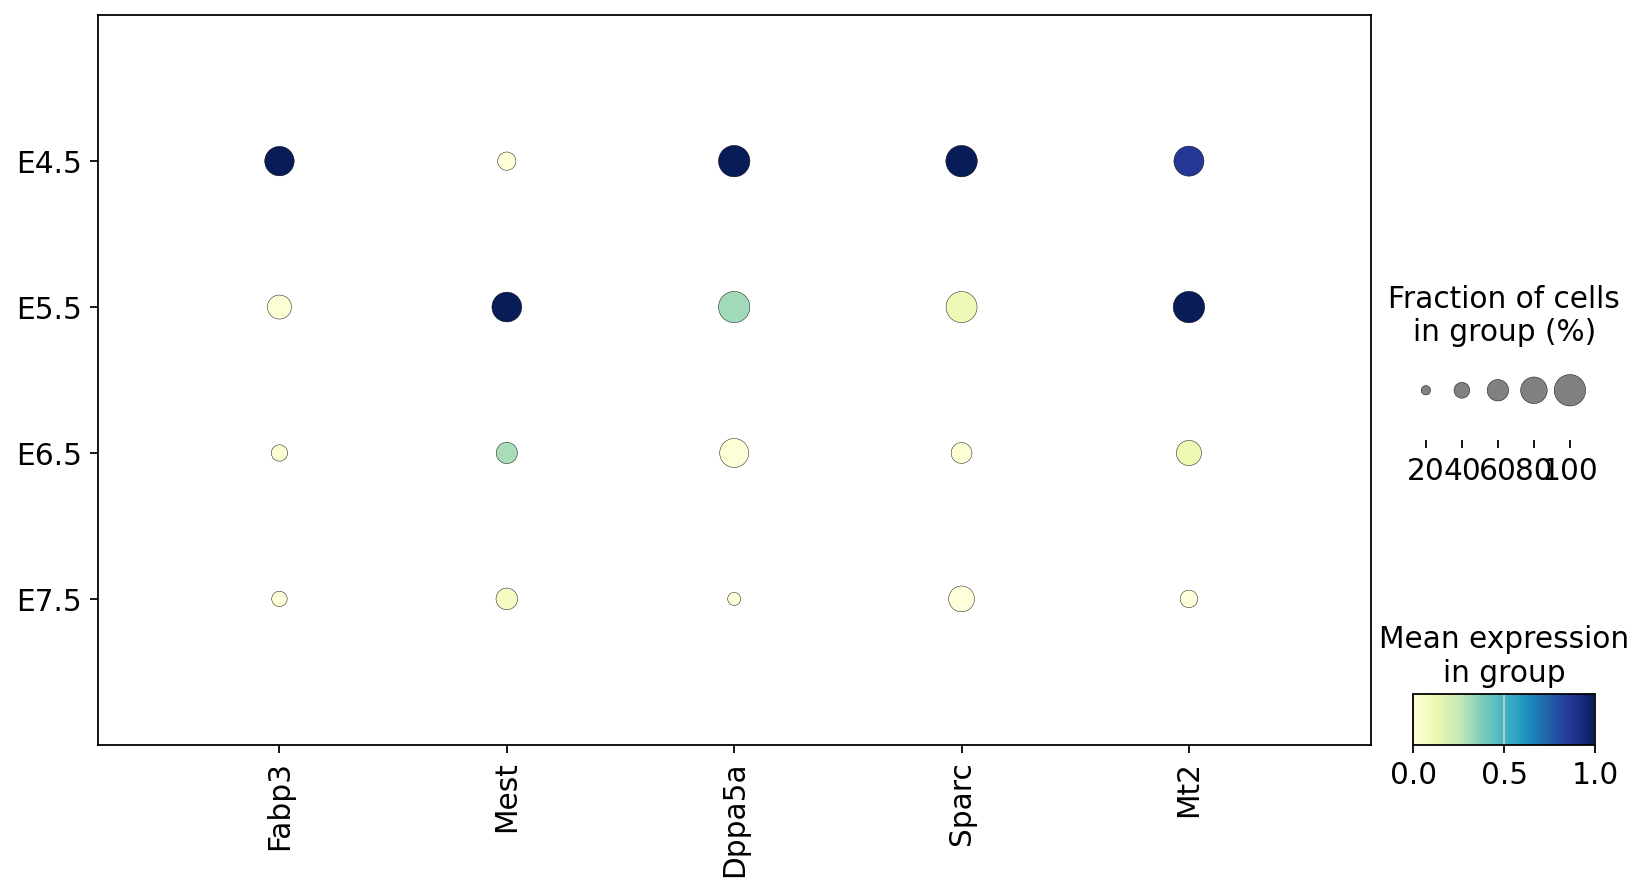

In [22]:
#Plot DOT PLOT for top 5 gene across all stages overall
sc.set_figure_params(scanpy=True, fontsize=16) 
sc.pl.dotplot(
    adata_temp,
    var_names=top_gene_symbols,
    groupby="stage",
    standard_scale="var",
    color_map="YlGnBu",
    show=True,
    dendrogram=False, 
    figsize=(12, 6),
    )

In [23]:

adata_sub = adata_combined[
    (adata_combined.obs["batch"] == "0") &
    (adata_combined.obs["stage"].isin(["E4.5", "E5.5"]))
]

adata_sub = adata_sub.copy()
model_sub = scvi.model.SCVI.load_query_data(adata_sub, vae)

de_res_E4_E5 = model_sub.differential_expression(
    groupby="stage",
    group1="E4.5",
    group2="E5.5",
    batch_correction=False,
    mode="change"  
)


adata_sub = adata_combined[adata_combined.obs["stage"].isin(["E6.5", "E7.5"])]

adata_sub = adata_sub.copy()

model_sub = scvi.model.SCVI.load_query_data(adata_sub, vae)

de_res_E6_E7 = model_sub.differential_expression(
    groupby="stage",
    group1="E6.5",
    group2="E7.5",
    batch_correction=True,
    mode="change"  
)

gene_map = adata_combined.var["gene_symbol"].to_dict()

top_genes = []

de_res = de_res_E4_E5.copy()
de_res["gene"] = de_res.index.map(gene_map)

de_res = de_res.dropna(subset=["lfc_mean", "proba_de"]).copy()
de_res["abs_lfc"] = de_res["lfc_mean"].abs()

top_e45 = de_res[(de_res["lfc_mean"] > 0) & (de_res["proba_de"] >= 0.95)]
if not top_e45.empty:
    top_gene_e45 = top_e45.sort_values("abs_lfc", ascending=False).iloc[0]
    top_gene_e45["stage"] = "E4.5"
    top_genes.append(top_gene_e45)

top_e55 = de_res[(de_res["lfc_mean"] < 0) & (de_res["proba_de"] >= 0.95)]
if not top_e55.empty:
    top_gene_e55 = top_e55.sort_values("abs_lfc", ascending=False).iloc[0]
    top_gene_e55["stage"] = "E5.5"
    top_genes.append(top_gene_e55)

de_res = de_res_E6_E7.copy()
de_res["gene"] = de_res.index.map(gene_map)

de_res = de_res.dropna(subset=["lfc_mean", "proba_de"]).copy()
de_res["abs_lfc"] = de_res["lfc_mean"].abs()

top_e65 = de_res[(de_res["lfc_mean"] > 0) & (de_res["proba_de"] >= 0.8)]
if not top_e65.empty:
    top_gene_e65 = top_e65.sort_values("abs_lfc", ascending=False).iloc[0]
    top_gene_e65["stage"] = "E6.5"
    top_genes.append(top_gene_e65)
    
top_e75 = de_res[(de_res["lfc_mean"] < 0) & (de_res["proba_de"] >= 0.8)]
if not top_e75.empty:
    top_gene_e75 = top_e75.sort_values("abs_lfc", ascending=False).iloc[0]
    top_gene_e75["stage"] = "E7.5"
    top_genes.append(top_gene_e75)

top_genes_df = pd.DataFrame(top_genes)
top_genes_df = top_genes_df[["stage", "gene", "lfc_mean", "proba_de"]].reset_index(drop=True)
print(top_genes_df)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

  stage    gene  lfc_mean  proba_de
0  E4.5   Wnt7b  3.520461  0.999800
1  E5.5     Id3 -2.571874  0.999800
2  E6.5  Dppa5a  2.755679  0.868347
3  E7.5  Cited2 -1.813755  0.822329


/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
... storing 'gene_symbol' as categorical
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
... storing 'gene_description' as categorical


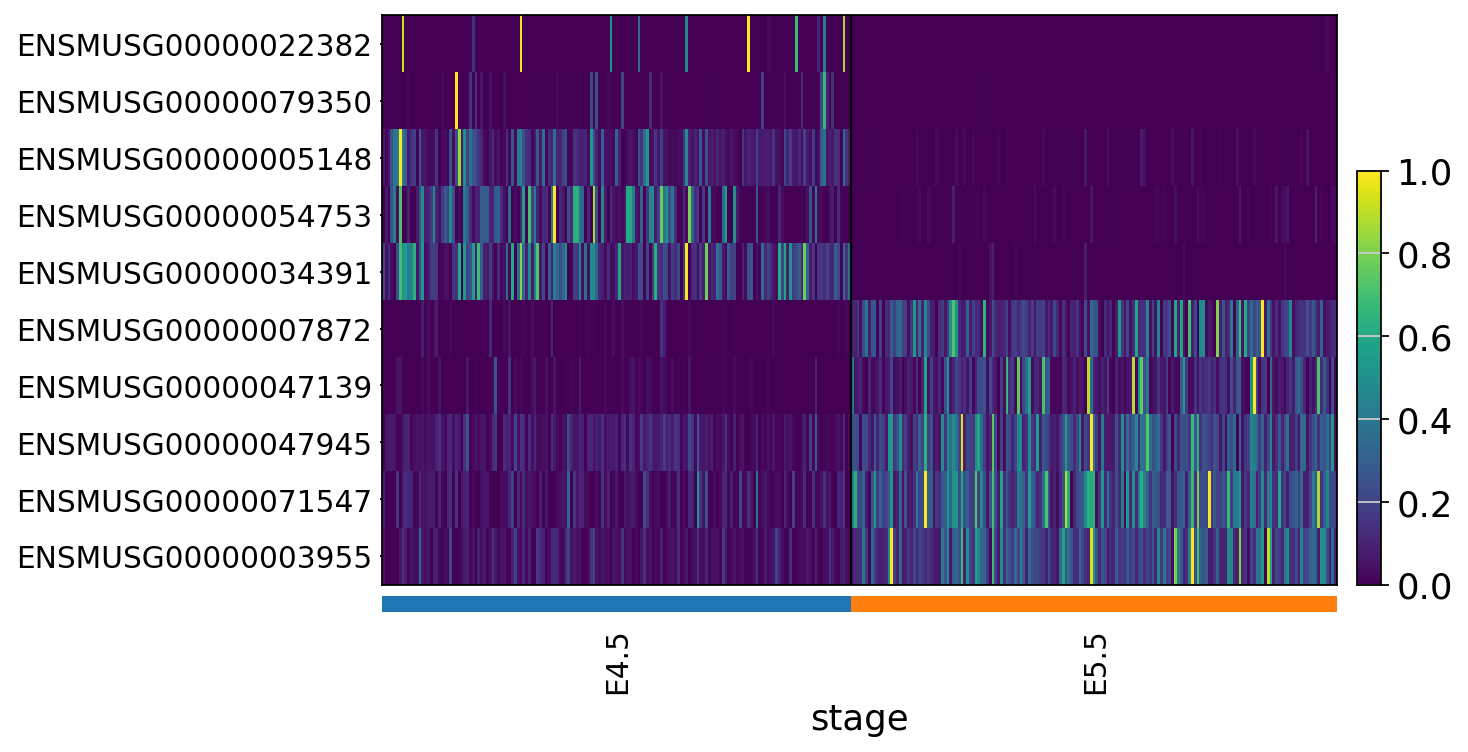

/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
... storing 'gene_symbol' as categorical
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
... storing 'gene_description' as categorical


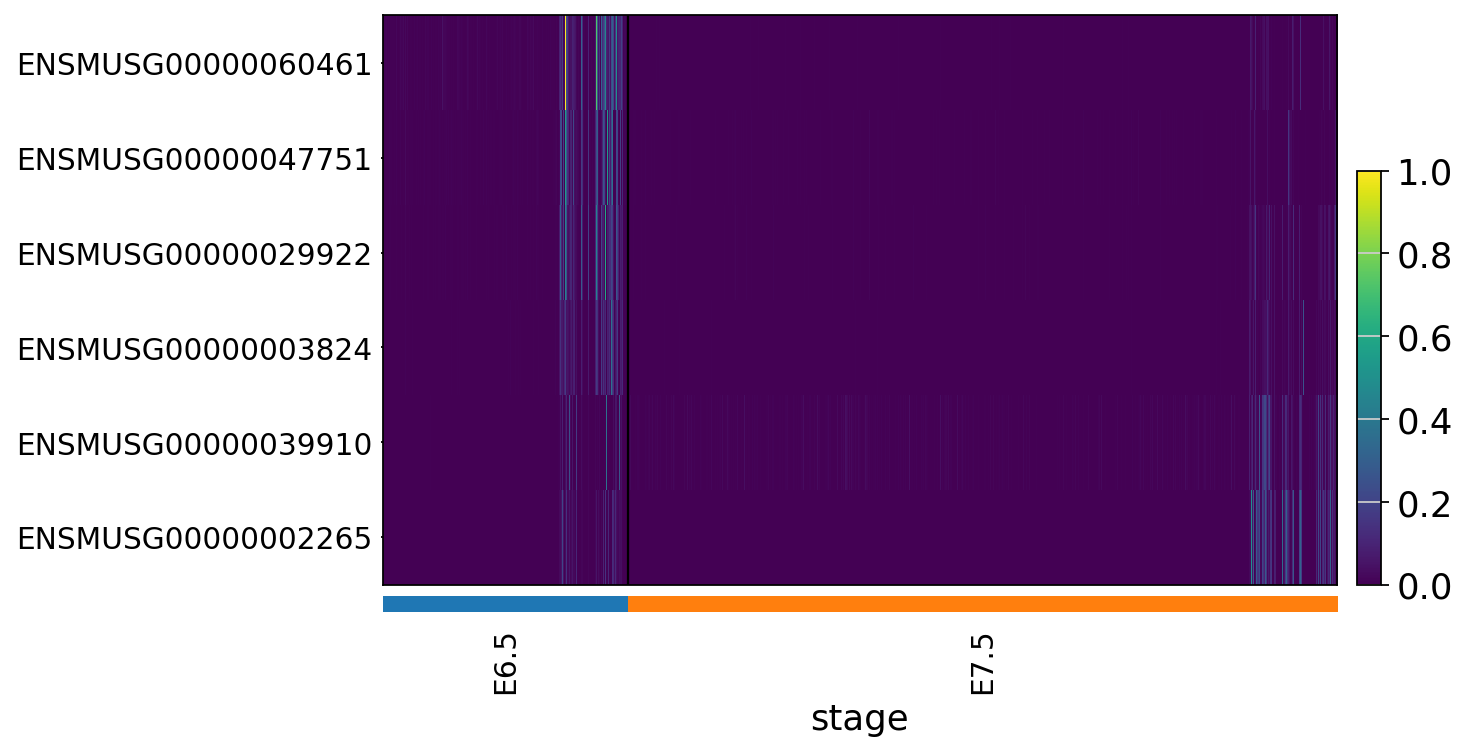

In [24]:
symbol_to_ensembl = adata_combined.var["gene_symbol"].dropna().to_dict()
ensembl_from_symbol = {v: k for k, v in symbol_to_ensembl.items()}

de_res = de_res_E4_E5.dropna(subset=["lfc_mean", "proba_de"]).copy()
de_res["abs_lfc"] = de_res["lfc_mean"].abs()
de_res["gene"] = de_res.index.map(adata_combined.var["gene_symbol"].to_dict())

top_e45 = de_res[(de_res["lfc_mean"] > 0) & (de_res["proba_de"] >= 0.95)]
top5_e45 = top_e45.sort_values("abs_lfc", ascending=False)["gene"].dropna().head(5).tolist()

top_e55 = de_res[(de_res["lfc_mean"] < 0) & (de_res["proba_de"] >= 0.95)]
top5_e55 = top_e55.sort_values("abs_lfc", ascending=False)["gene"].dropna().head(5).tolist()

top_genes_symbols = top5_e45 + top5_e55
top_genes_ensembl = [ensembl_from_symbol[g] for g in top_genes_symbols if g in ensembl_from_symbol]

adata_e4e5 = adata_combined[adata_combined.obs["stage"].isin(["E4.5", "E5.5"])]

sc.pl.heatmap(
    adata_e4e5,
    var_names=top_genes_ensembl,
    groupby="stage",
    standard_scale="var",
    cmap="viridis",
    dendrogram=False,
    swap_axes=True,
    figsize=(8, 5),
    show=True
)


symbol_to_ensembl = adata_combined.var["gene_symbol"].dropna().to_dict()
ensembl_from_symbol = {v: k for k, v in symbol_to_ensembl.items()}

de_res = de_res_E6_E7.dropna(subset=["lfc_mean", "proba_de"]).copy()
de_res["abs_lfc"] = de_res["lfc_mean"].abs()
de_res["gene"] = de_res.index.map(adata_combined.var["gene_symbol"].to_dict())

top_e65 = de_res[(de_res["lfc_mean"] > 0) & (de_res["proba_de"] >= 0.80)]
top5_e65 = top_e65.sort_values("abs_lfc", ascending=False)["gene"].dropna().head(5).tolist()

top_e75 = de_res[(de_res["lfc_mean"] < 0) & (de_res["proba_de"] >= 0.80)]
top5_e75 = top_e75.sort_values("abs_lfc", ascending=False)["gene"].dropna().head(5).tolist()

top_genes_symbols = top5_e65 + top5_e75
top_genes_ensembl = [ensembl_from_symbol[g] for g in top_genes_symbols if g in ensembl_from_symbol]

adata_e6e7 = adata_combined[adata_combined.obs["stage"].isin(["E6.5", "E7.5"])]

sc.pl.heatmap(
    adata_e6e7,
    var_names=top_genes_ensembl,
    groupby="stage",
    standard_scale="var",
    cmap="viridis",
    dendrogram=False,
    swap_axes=True,
    figsize=(8, 5),
    show=True
)

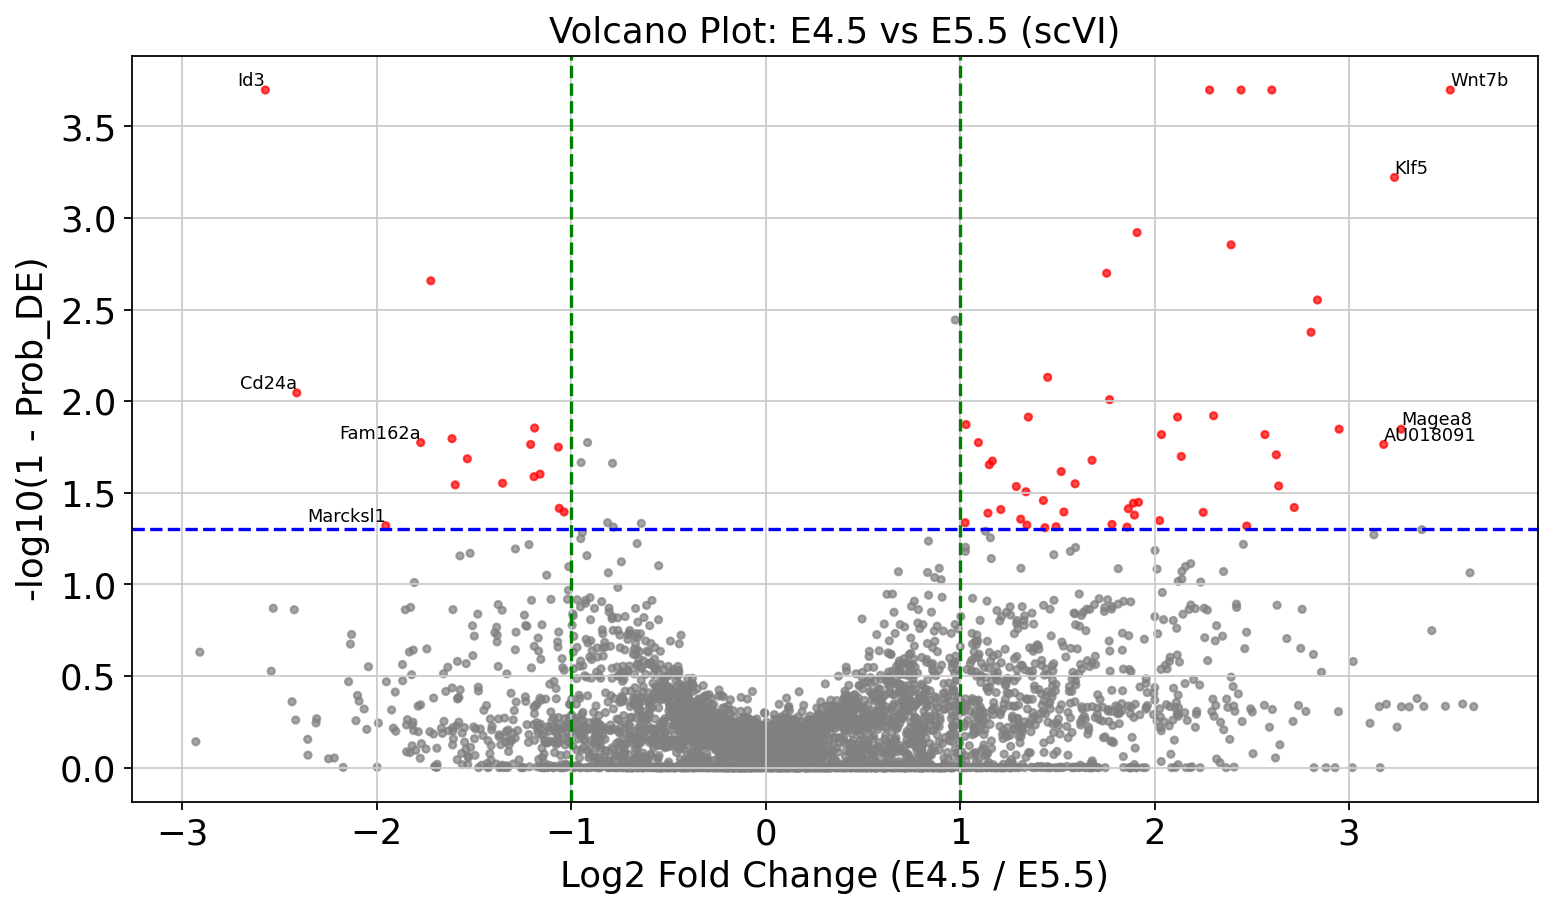

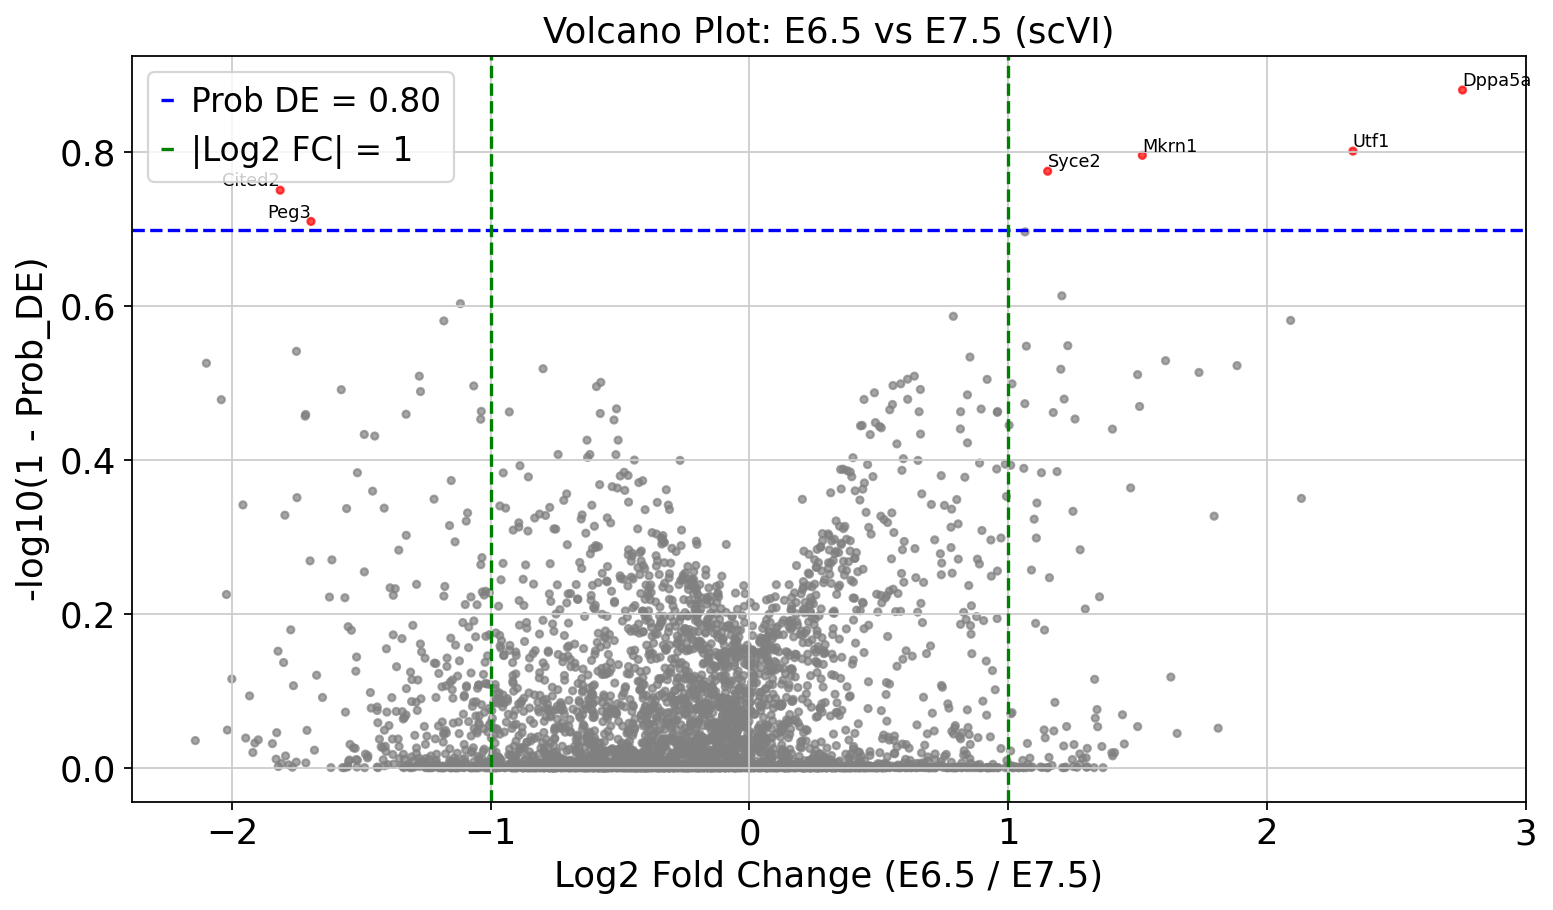

In [25]:
de_res_clean = de_res_E4_E5.dropna(subset=["lfc_mean", "proba_de"]).copy()
de_res_clean["neg_log10_pseudo_pval"] = -np.log10(1 - de_res_clean["proba_de"])

gene_map = adata_combined.var["gene_symbol"].to_dict()
de_res_clean["gene_symbol"] = de_res_clean.index.map(gene_map)

de_res_clean["highlight"] = (
    (de_res_clean["proba_de"] >= 0.95) &
    (de_res_clean["lfc_mean"].abs() >= 1)
)
genes_to_label = top5_e55+top5_e45

plt.figure(figsize=(10, 6))
plt.scatter(
    de_res_clean["lfc_mean"],
    de_res_clean["neg_log10_pseudo_pval"],
    c=de_res_clean["highlight"].map({True: "red", False: "grey"}),
    s=10,
    alpha=0.7
)

for _, row in de_res_clean.iterrows():
    if row["gene_symbol"] in genes_to_label:
        plt.text(
            row["lfc_mean"],
            row["neg_log10_pseudo_pval"],
            row["gene_symbol"],
            fontsize=8,
            ha='right' if row["lfc_mean"] < 0 else 'left',
            va='bottom'
        )

plt.axhline(y=-np.log10(1 - 0.95), color="blue", linestyle="--", label="Prob DE = 0.95")
plt.axvline(x=1, color="green", linestyle="--", label="|Log2 FC| = 1")
plt.axvline(x=-1, color="green", linestyle="--")

plt.title("Volcano Plot: E4.5 vs E5.5 (scVI)")
plt.xlabel("Log2 Fold Change (E4.5 / E5.5)")
plt.ylabel("-log10(1 - Prob_DE)")
#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

de_res_clean = de_res_E6_E7.dropna(subset=["lfc_mean", "proba_de"]).copy()
de_res_clean["neg_log10_pseudo_pval"] = -np.log10(1 - de_res_clean["proba_de"])

gene_map = adata_combined.var["gene_symbol"].to_dict()
de_res_clean["gene_symbol"] = de_res_clean.index.map(gene_map)

de_res_clean["highlight"] = (
    (de_res_clean["proba_de"] >= 0.80) & 
    (de_res_clean["lfc_mean"].abs() >= 1)
)

genes_to_label = top5_e65+top5_e75

plt.figure(figsize=(10, 6))
plt.scatter(
    de_res_clean["lfc_mean"],
    de_res_clean["neg_log10_pseudo_pval"],
    c=de_res_clean["highlight"].map({True: "red", False: "grey"}),
    s=10,
    alpha=0.7
)

for _, row in de_res_clean.iterrows():
    if row["gene_symbol"] in genes_to_label:
        plt.text(
            row["lfc_mean"],
            row["neg_log10_pseudo_pval"],
            row["gene_symbol"],
            fontsize=8,
            ha='right' if row["lfc_mean"] < 0 else 'left',
            va='bottom'
        )

plt.axhline(y=-np.log10(1 - 0.80), color="blue", linestyle="--", label="Prob DE = 0.80")
plt.axvline(x=1, color="green", linestyle="--", label="|Log2 FC| = 1")
plt.axvline(x=-1, color="green", linestyle="--")

plt.title("Volcano Plot: E6.5 vs E7.5 (scVI)")
plt.xlabel("Log2 Fold Change (E6.5 / E7.5)")
plt.ylabel("-log10(1 - Prob_DE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
